# Librerias
Se hace uso de un conjunto de librerias para el analisis de datos.

In [134]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import SpectralClustering,AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram,linkage
import time
import json
import codecs
from sklearn.cluster import KMeans
from functools import reduce
import operator 
from sklearn.metrics import calinski_harabasz_score as chs,davies_bouldin_score as dbs,silhouette_score as shs
from scipy.sparse.csgraph import laplacian
from numpy.random import RandomState,BitGenerator
import warnings
from scipy.sparse.csgraph import shortest_path
from validclust.validclust.indices import dunn
plt.rcParams["figure.figsize"] = (15,15)
warnings.filterwarnings("ignore")

ss = preprocessing.StandardScaler()
ac = AgglomerativeClustering()

# Funciones de utileria
Funciones las cuales se utilizan de una forma recurrente.

In [135]:
def standarize(**kwargs):
    X = kwargs['X']
    scaler = ss.fit(X)
    return scaler.transform(X)

# Importar dataset
Se importan los datos utilizando Pandas

In [257]:
df1 = pd.read_csv('./data/op02.csv')
df2 = pd.read_csv('./data/op01.csv')
df  = pd.concat([df1,df2])
oldCols =df.columns
columns = df.columns
useless_cols = ["OPERATION_ID","USER_ID","TYPE","TOPIC_ID","TOPIC_ROLE","USER_ROLE","FILE_ID"]
df.head(3)

,OPERATION_ID,TYPE,USER_ID,PRODUCTION,CONSUME,CONSUME_OTHERS,USER_VOLUME,USER_DENSITY,USER_ROLE,FILE_ID,FILE_SIZE,TOPIC_ID,TOPIC_VOLUME,TOPIC_DENSITY,TOPIC_ROLE
0,1,UPLOAD,251478729,0.008411,0.016822,0.050467,1248,1304.866641,Gamma,38,2,3,7790920,154761.833245,Alpha
1,1,UPLOAD,251478729,0.008411,0.016822,0.050467,1248,1304.866641,Gamma,134,10,12,33670104,621071.733518,Beta
2,1,DOWNLOAD,251478729,0.008411,0.016822,0.050467,1248,1304.866641,Gamma,38,2,3,7790920,154761.833245,Alpha


# Visualizar informacion del dataset
Se muestra la informacion basica sobre el conjunto de datos, como los tipos de cada columna y su nombre y el tamaño en Megabytes

In [271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32771 entries, 0 to 8992
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OPERATION_ID    32771 non-null  int64  
 1   TYPE            32771 non-null  object 
 2   USER_ID         32771 non-null  int64  
 3   PRODUCTION      32771 non-null  float64
 4   CONSUME         32771 non-null  float64
 5   CONSUME_OTHERS  32771 non-null  float64
 6   USER_VOLUME     32771 non-null  int64  
 7   USER_DENSITY    32771 non-null  float64
 8   USER_ROLE       1319 non-null   object 
 9   FILE_ID         32771 non-null  int64  
 10  FILE_SIZE       32771 non-null  int64  
 11  TOPIC_ID        32771 non-null  int64  
 12  TOPIC_VOLUME    32771 non-null  int64  
 13  TOPIC_DENSITY   32771 non-null  float64
 14  TOPIC_ROLE      32771 non-null  object 
dtypes: float64(5), int64(7), object(3)
memory usage: 5.3+ MB


# Resumen estadistico
Se realiza un resumen estadistico de las columnas, el cual contiene 8 columnas, entre las cuales se encuentran:
- **count**: Cantidad de registros 
- **mean** : La media aritmetica 
- **std**  : La desviacion estandar 
- **min**  : Valor minimo 
- **25%**  : Percentil 25
- **50%**  : Percentil 50 el cual es equivalente a la mediana
- **75%**  : Percentil 75
- **max**  : Valor maximo

In [272]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
OPERATION_ID,32771.0,8.304130e+03,5.836288e+03,1.00,3.341000e+03,6.941000e+03,1.310050e+04,2.026200e+04
USER_ID,32771.0,8.108804e+08,8.335594e+08,4163.00,1.774968e+08,3.705717e+08,1.506215e+09,2.917676e+09
PRODUCTION,32771.0,3.782092e-04,2.427325e-03,0.00,0.000000e+00,0.000000e+00,0.000000e+00,6.671856e-02
CONSUME,32771.0,1.120545e-02,2.503432e-02,0.00,4.205568e-03,4.205568e-03,1.111976e-02,4.781497e-01
CONSUME_OTHERS,32771.0,2.305597e-02,2.299075e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.000778e+01
USER_VOLUME,32771.0,7.965800e+03,1.696910e+05,0.00,0.000000e+00,0.000000e+00,0.000000e+00,7.740000e+06
USER_DENSITY,32771.0,6.226255e+02,9.465923e+03,0.00,0.000000e+00,0.000000e+00,0.000000e+00,4.878586e+05
FILE_ID,32771.0,1.468878e+02,1.037777e+02,1.00,5.700000e+01,1.130000e+02,2.370000e+02,3.530000e+02
FILE_SIZE,32771.0,5.142168e+00,1.960774e+00,1.00,4.000000e+00,5.000000e+00,6.000000e+00,1.000000e+01
TOPIC_ID,32771.0,1.275933e+01,7.348027e+00,1.00,7.000000e+00,1.300000e+01,1.800000e+01,2.600000e+01


# Productores
Se filtran los usuarios productores utilizando la columna **USER_ROLE** 

In [273]:
producers = df1.loc[df1['USER_ROLE'].isna() != True]
producers = producers.loc[producers['TYPE']=='UPLOAD']
# .loc[df['TYPE']=='UPLOAD']
# X= pd.pivot_table(producers,index=['USER_ID'],values=['PRODUCTION'])
producers
# X.sum()

,OPERATION_ID,TYPE,USER_ID,PRODUCTION,CONSUME,CONSUME_OTHERS,USER_VOLUME,USER_DENSITY,USER_ROLE,FILE_ID,FILE_SIZE,TOPIC_ID,TOPIC_VOLUME,TOPIC_DENSITY,TOPIC_ROLE
0,1,UPLOAD,251478729,0.008411,0.016822,0.050467,1248,1304.866641,Gamma,38,2,3,7790920,154761.833245,Alpha
1,1,UPLOAD,251478729,0.008411,0.016822,0.050467,1248,1304.866641,Gamma,134,10,12,33670104,621071.733518,Beta
7,3,UPLOAD,2243532154,0.008411,0.008411,0.012617,36,23.533334,Gamma,185,4,7,20247384,314153.816647,Beta
8,3,UPLOAD,2243532154,0.008411,0.008411,0.012617,36,23.533334,Gamma,299,4,21,5777280,227799.000314,Gamma
11,4,UPLOAD,191780822,0.004206,0.004206,0.008411,12,7.433334,Gamma,201,3,14,2462290,161309.083032,Gamma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22773,19397,UPLOAD,986959732,0.004206,0.050467,0.630835,112500,39950.500021,Gamma,337,5,3,7790920,154761.833245,Alpha
22908,19512,UPLOAD,6860189,0.004206,0.000000,0.630835,135000,132404.316956,Gamma,179,6,12,33670104,621071.733518,Beta
23091,19647,UPLOAD,12900868,0.004206,0.016822,0.159812,4332,6665.983369,Gamma,266,3,23,295452,34325.750006,Gamma
23124,19672,UPLOAD,511681663,0.004206,0.079906,0.164017,6084,5063.366640,Gamma,149,4,26,405512,16090.749969,Gamma


## Distribucion de los datos
Se muestra la kernel density estimation (KDE) la estima la distribucion probabilistica de los datos

In [274]:
Xp         = producers.drop(useless_cols,axis=1) 
Xp_columns = Xp.columns
displot = lambda x: sns.displot(data=Xp,x=x,height=5,kde=True,color='black')

### Produccion
Porcentaje de produccion de un usario productor

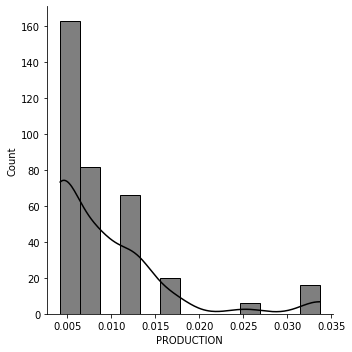

In [275]:
displot(Xp_columns[0])

## Consumo
Porcentaje de consumo realizo por un usuario 

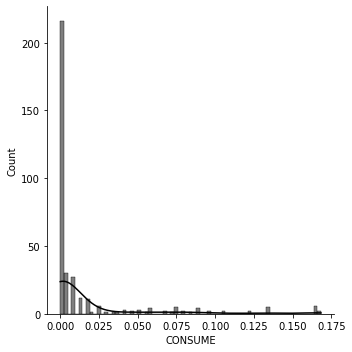

In [276]:
displot(Xp_columns[1])

## Consumido por otros usuarios
Porcentaje que representa lo que es consumido por otros usuarios.

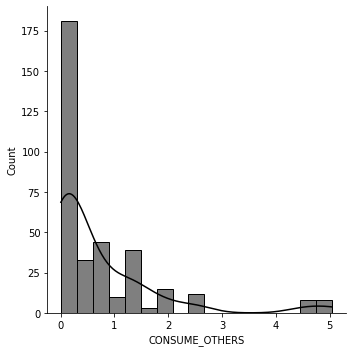

In [277]:
displot(Xp_columns[2])

## Volumen de usuario
Cantidad en bytes, el consumo de almacenamiento de un sistema CDS al servidor las peticiones de descarga

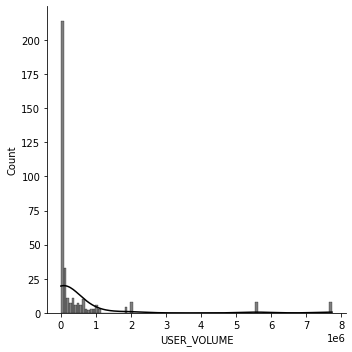

In [278]:
displot(Xp_columns[3])

## Densidad de usuario
El tiempo promedio entre las peticiones

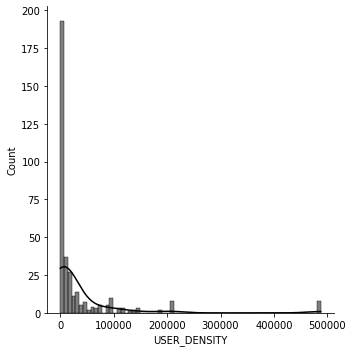

In [280]:
displot(Xp_columns[4])

##  Tamaño de archivos
Tamaño de un archivo en megabytes

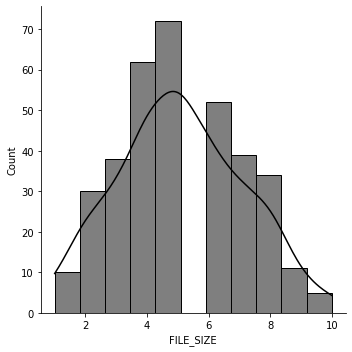

In [279]:
displot(Xp_columns[5])

## Volumen  de tema
Consumo de almacenamiento el cual es generado por los archivos los cuales son clasificados con el tema.

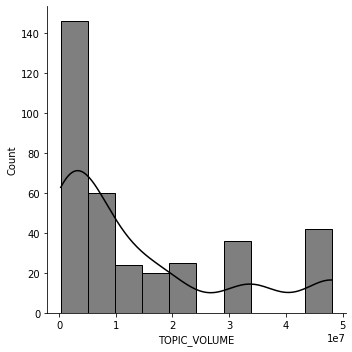

In [281]:
displot(Xp_columns[6])

## Densidad de tema
El tiempo promedio entre las peticiones de los archivos que tratan del tema.

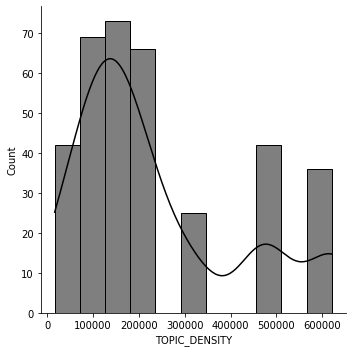

In [282]:
displot(Xp_columns[7])

## Elimando Outliers
Utilizando el rango intercuartil, los valores atípicos se definen como observaciones que caen por debajo de Q1 - 1.5 IQR o por encima de Q3 + 1.5 IQR.

In [284]:
for col in Xp_columns:
    Q1 = Xp[col].quantile(0.25)
    Q3 = Xp[col].quantile(0.75)
    IQR = Q3 - Q1 
    filter = (df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 *IQR)
    Xp = Xp.loc[filter] 
#     sns.boxplot(x=Xp[col],width=.5,color="red",fliersize=20)

# Consumidores
Se filtran usuarios consumidores utilizando la columna **USER_ROLE**, la cual es nula en caso de ser consumidor.

In [285]:
consumers     = df.loc[df1['USER_ROLE'].isna()]
Y             = pd.pivot_table(consumers,index=['USER_ID'],values=['CONSUME'])
Y
# consumers
# Y['CONSUME'].sum()
# consumers.head(5)

,CONSUME
USER_ID,
4163,0.004206
6161,0.011120
7128,0.008411
13357,0.004206
18107,0.004206
...,...
2917621259,0.004206
2917659673,0.004206
2917666785,0.004206


# Archivos
Se extraen los archivos los cuales son cargados por los usuarios productores.

In [286]:
files   = producers[producers['TYPE']=='UPLOAD']
files   = files.sort_values('FILE_ID')
files   = files[['FILE_ID','FILE_SIZE','TOPIC_ID','TOPIC_VOLUME','TOPIC_DENSITY','TOPIC_ROLE']]
files

,FILE_ID,FILE_SIZE,TOPIC_ID,TOPIC_VOLUME,TOPIC_DENSITY,TOPIC_ROLE
16503,1,5,13,2992375,136087.183300,Gamma
20291,2,2,16,1445325,105013.899899,Gamma
18275,3,4,13,2992375,136087.183300,Gamma
7518,4,7,7,20247384,314153.816647,Beta
7517,5,6,2,8456427,117043.133370,Alpha
...,...,...,...,...,...,...
20197,349,3,19,12072698,184549.450049,Alpha
14860,350,5,24,15999456,232859.933558,Alpha
20289,351,4,21,5777280,227799.000314,Gamma
4580,352,6,9,2172744,180949.433712,Gamma


# Temas
Se extraen los temas los cuales son asignados a los archivos

In [287]:
topics  = files[['TOPIC_ID','TOPIC_VOLUME','TOPIC_DENSITY']] 
_topics = topics.drop_duplicates()
_topics = _topics.sort_values('TOPIC_ID')
_topics.shape

(26, 3)

# Spectral & Agglomerative Clustering

## Creacion del grafo
La generacion se lleva acabo utilizando **Neo4j**, una base de datos basada en grafos.

In [165]:
from neo4j import GraphDatabase

In [222]:
class Neo4J:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def getSession(self):
        return self.driver.session()
    def print_greeting(self, message):
        with self.getSession() as session:
            greeting = session.write_transaction(self._create_and_return_greeting, message)
            print(greeting)
    def writeTransaction(self,fx,*args,**kwargs):
        return self.getSession().write_transaction(fx,*args,**kwargs)


def setToCluster(tx,data):
    
    query = """
        MATCH (n) WHERE n.nid IN $node_ids
            SET n: {}
            RETURN n
    """.format(data[1])
#     query = """
#         MATCH (n) WHERE id(n) IN $node_ids
#             SET n: {}
#             RETURN n
#     """.format(data[1])
    return tx.run(query,node_ids=data[0])
def createConsumer(tx,data):
    user_id = data[0]
    consume = data[1]
    file_id = data[2]
    query ="""
    MATCH (f:File {file_id:$file_id})
    MERGE (c:Consumer {user_id: $user_id,consume:$consume })
    MERGE (f)<-[d:DOWNLOAD]-(c)
    ON CREATE SET d.count =1
    ON MATCH SET d.count = d.count+1
    RETURN f,d,c
    """
    
    return tx.run(query,user_id=user_id,consume=consume,file_id=file_id)

def createProducer(tx,data):
    user_id        = data[0]
    production     = data[1] 
    consume        = data[2]
    consume_others = data[3]
    user_volume    = data[4]
    user_density   = data[5]
    user_role      = data[6]
    file_id        = data[7]
    file_size      = data[8]
    topic_id       = data[9]
    topic_volume   = data[10]
    topic_density  = data[11]
    topic_role     = data[12]
#     query = """
#         MERGE (p:Producer {user_id:$user_id,production:$production,volume:$volume,density:$density,consume:$consume,consume_others:$consume_others,role:$role})
#         MERGE (f:File {file_id:$file_id,size:$file_size})
#         MERGE (t:Topic {topic_id: $topic_id,volume:$topic_volume,density: $topic_density,role:$topic_role})
#         MERGE (p)-[u:UPLOAD]->(f)-[ht:HAS_TOPIC]->(t)
#         RETURN p,u,f,ht,t
#     """
    query = """
        MERGE (p:Producer {user_id:$user_id,production:$production,volume:$volume,density:$density,consume:$consume,consume_others:$consume_others,role:$role})
        MERGE (t:Topic {topic_id: $topic_id,volume:$topic_volume,density: $topic_density,role:$topic_role})
        MERGE (p)-[u:UPLOAD]->(t)
        RETURN p,u,t
    """
    
    return tx.run(query,
                        user_id=user_id,
                        production=production,
                        volume=user_volume,
                        density=user_density,
                        consume=consume,
                        consume_others=consume_others,
                        role=user_role,
                        file_id=file_id,
                        file_size=file_size,
                        topic_id=topic_id,
                        topic_volume=topic_volume,
                        topic_density=topic_density,
                        topic_role=topic_role
                 )
db = Neo4J("bolt://localhost:7687", "neo4j", "password")
# x = db.writeTransaction(fx=getPersons)
# print(x,len(x))
# db.close()

# Crear Productores
Se crean los productores utilizando la API de **Neo4j**

In [197]:
# producers_data = producers[['USER_ID','PRODUCTION','CONSUME','CONSUMER_OTHERS','USER_VOLUME','USER_DENSITY','USER_ROLE']]
producers_data  = producers.copy()
# producers_data.sort_values("USER_ROLE").head()
# producers_data  = producers_data.loc[producers_data['TYPE'] == 'UPLOAD']
producers_data  = producers_data.drop(["OPERATION_ID","TYPE"],axis=1)
# print(producers_data.shape)
producers_data  = producers_data.to_numpy().tolist()
# producers_data = producers_data.to_numpy()
# producers_data.head(5)
def runCreateProducers():
    for data in producers_data:
        db.writeTransaction(createProducer,data)
        print("Producer[{}] created".format(data[0]))
        time.sleep(.2)
    db.close()
# producers_data
# runCreateProducers()

Se muestra el resultado que se obtiene, utilizando la herramienta de visualizacion de **Neo4j**. 

![title](images/p0.png)

En la misma operacion se lleva acabo la creacion de los archivos y la relacion de carga con el usuario productor

![title](images/puf.png)

A continuacion se muestra una imagen de los productores, la realacion de carga de archivos y los temas a los que pertenecen los archivos

![title](images/pufhtt.png)

# Crear consumidores
Se crearon los consumidores

In [542]:
consumers_data = consumers.copy()
consumers_data = consumers_data.drop(['TYPE','FILE_SIZE','TOPIC_ID','TOPIC_VOLUME','TOPIC_DENSITY','OPERATION_ID','CONSUME_OTHERS','USER_VOLUME','USER_DENSITY','USER_ROLE','PRODUCTION','TOPIC_ROLE'], axis=1)
# consumers_data[consumers_data['FILE_ID']==113]
consumers_data = consumers_data.to_numpy().tolist()[100:]

def runCreateConsumers(data):
    for c in data:
        db.writeTransaction(createConsumers,c)
        print("Consumer[{}]".format(c[0]))
        time.sleep(.2)
# runCreateConsumers(consumers_data)
# consumers_data[100:]['FILE_ID'].unique()

El resultado de los consumidores, unicamente se muestran 2000 nodos, pero en realidad existen 8000 consumidores. 

![title](images/c2.png)

# Creacion de matriz de adyacencia
En teoría de grafos y ciencias de la computación, una matriz de adyacencia es una matriz cuadrada que se usa para representar un gráfico finito.

In [227]:
A = np.load('./data/am.npy')
A

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

# Matriz de proximidad

In [228]:
SPA = shortest_path(A,directed = False)
SPA[SPA == np.inf] =0
SPA

array([[ 0.,  1.,  2., ..., 19., 12., 11.],
       [ 1.,  0.,  1., ..., 18., 11., 10.],
       [ 2.,  1.,  0., ..., 17., 10.,  9.],
       ...,
       [19., 18., 17., ...,  0., 23., 22.],
       [12., 11., 10., ..., 23.,  0.,  1.],
       [11., 10.,  9., ..., 22.,  1.,  0.]])

# Matriz de grados
En teoría de grafos, la matriz de grados es una matriz diagonal que contiene información sobre el grado de cada vértice.

In [229]:
D = np.diag(A.sum(axis=1))
D

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  2.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 15., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  2.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  2.]])

# Laplacian
La teoría de grafos, la matriz laplaciana, también llamada grafo laplaciano, matriz de admitancia, matriz de Kirchhoff o laplaciana discreta, es una representación matricial de un grafo. La matriz laplaciana se puede utilizar para encontrar muchas propiedades útiles de un gráfico.

In [230]:
L = D-A
L

array([[ 1., -1.,  0., ...,  0.,  0.,  0.],
       [-1.,  2., -1., ...,  0.,  0.,  0.],
       [ 0., -1., 15., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  2.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1., -1.],
       [ 0.,  0.,  0., ...,  0., -1.,  2.]])

# Eigenvalues y Eigenvector

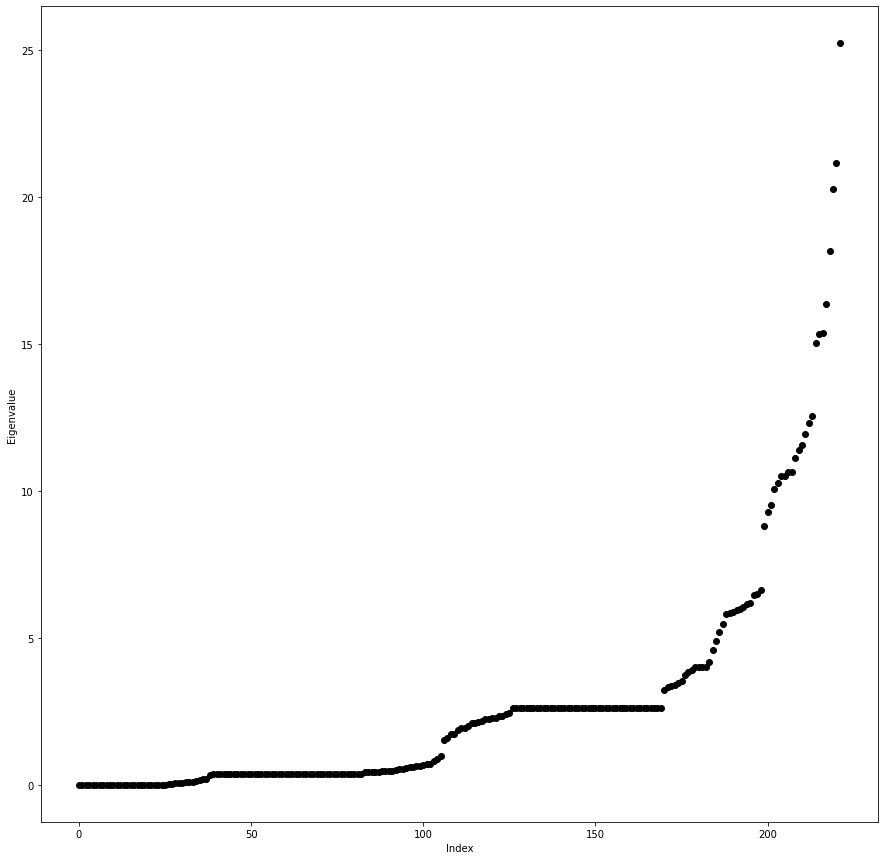

In [231]:
# import scipy as scp
vals, vecs = np.linalg.eigh(L)
# vals, vecs = np.linalg.eig(L)
vecs = vecs[:,np.argsort(vals)]
vals = vals[np.argsort(vals)]
# vecs.shape,vals.shape
fg,ax =plt.subplots()
ax.set_xlabel("Index")
ax.set_ylabel("Eigenvalue")
ax.scatter(range(vals.shape[0]),vals,color ="black")
# plt.savefig("./images/eigenvals.jpg")
# sns.scatterplot(range(vals.shape[0]),vals,ax=ax)
# vecs


# Utilerias para pruebas

In [215]:

def prepareScorePlot():
    fig, ax    = plt.subplots(len(score_names),1)
    def f(i,scores,labels):
        ax[i].plot(n_clusters,scores[0],'r--',label = labels[0])
        ax[i].plot(n_clusters,scores[1],'b--',label = labels[1])
        ax[i].set_xlabel("Num. Clusters")
        ax[i].set_ylabel("Score")
        ax[i].set_xticks(n_clusters)
        ax[i].legend(loc='best')
    return f
        
def neo4jPlot(data):
    for d in data:
        db.writeTransaction(setToCluster,d)
def plotScoresByScoreName(**kwargs):
    labels = kwargs['labels']
    data   = kwargs['data']
    score_names = kwargs['score_names']
    f = prepareScorePlot() 
    for i,key in enumerate(score_names):
        f(i,data[key],labels[key])

# Pruebas

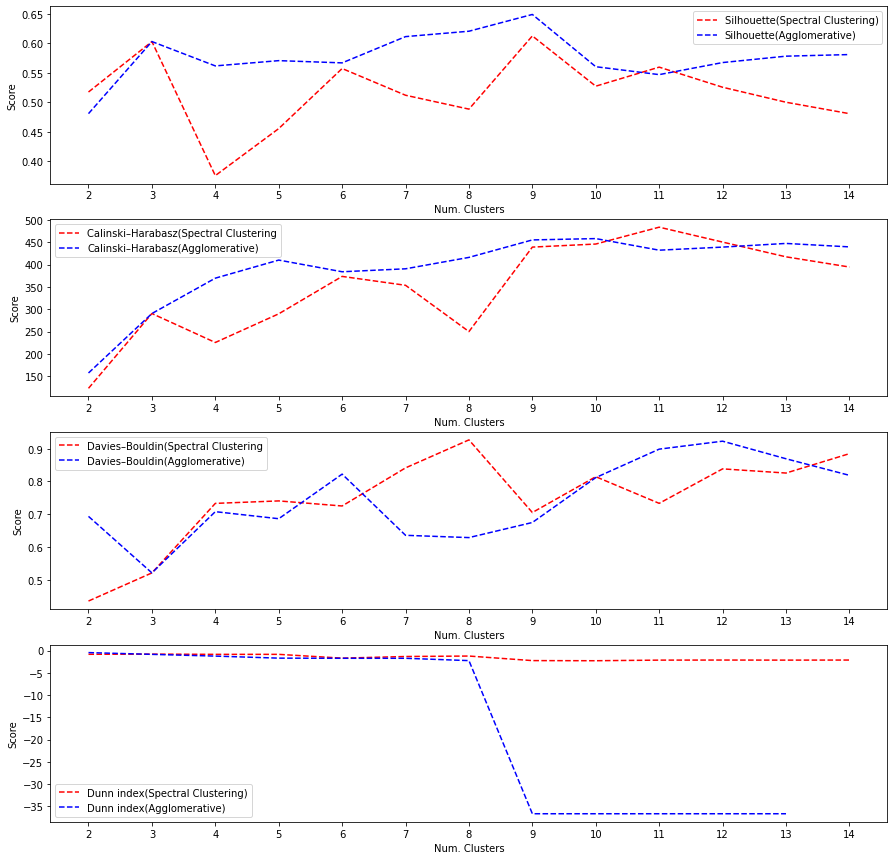

In [232]:
# clusters = (2,5,10,15,20)
eigen_solvers =('arpack', 'lobpcg', 'amg') #The eigenvalue decomposition strategy to use
n_components  = 6 # Number of eigen vectors to use for the spectral embedding
random_satate = (RandomState(None),10) # A pseudo random number generator used for the initialization of the lobpcg eigen vectors decomposition when eigen_solver='amg' and by the K-Means initialization
n_init        = 10 # Number of time the k-means algorithm will be run with different centroid seeds. 
gamma         = 1.0 # Kernel coefficient for rbf, poly, sigmoid, laplacian and chi2 kernels
affinity      = ('precomputed','nearest_neighbors','rbf','precomputed_nearest_neighbors')
n_neighbors   = 10 # Number of neighbors to use when constructing the affinity matrix using the nearest neighbors method
eigen_tol     = 0.0 # Stopping criterion for eigendecomposition of the Laplacian matrix when eigen_solver='arpack'
assign_labels = ('kmeans','discretize') # The strategy to use to assign labels in the embedding space
degree        = 3 # Degree of the polynomial kernel. Ignored by other kernels
coef0         = 1 # Zero coefficient for polynomial and sigmoid kernels.
n_jobs        = -1 # -1 means using all processors.
verbose       = True
def runSC(**kwargs):
    #score_results =[[],[],[],[],[],[]]
    score_results = {'sh':([],[]),'ch':([],[]),'db':([],[]),'dun':([],[])}
    show_scores   = kwargs['show_scores']
#     spec
    visualize     = kwargs['visualize']
    X             = kwargs['X']
    sX            = standarize(X=X)
    clusters      = kwargs['n_clusters']
    for k in clusters:
        agglomerativeClus = AgglomerativeClustering(
            n_clusters=k,
            affinity='euclidean',
            connectivity=A).fit(sX)
        
        spectralClus = SpectralClustering(n_clusters=k,
                                n_components=k,
                                assign_labels=assign_labels[0],
                                random_state=random_satate[0],
                                affinity=affinity[1],
                                eigen_solver=eigen_solvers[0]
                               ).fit(X)
#         
        spectralClusLabels      = spectralClus.labels_
        agglomerativeClusLabels = agglomerativeClus.labels_
        scUniqueLabels          = np.unique(spectralClusLabels)
        acUniqueLabels          = np.unique(agglomerativeClusLabels)
        if(visualize):
            scColors =  list(map(lambda x: [np.where(spectralClusLabels==x)[0].tolist(),'C'+str(x),x],scUniqueLabels))
            neo4jPlot(scColors)
            input("Continue")
            agColors =  list(map(lambda x: [np.where(agglomerativeClusLabels==x)[0].tolist(),'C'+str(x),x],acUniqueLabels))
            neo4jPlot(agColors)
            input("Continue")
        
        if(show_scores):
            sillhoutte_scores = (shs(sX,spectralClusLabels), shs(sX,agglomerativeClusLabels))
            calinki_scores =(chs(sX,spectralClusLabels), chs(sX,agglomerativeClusLabels))
            davies_scores  = (dbs(sX,spectralClusLabels),dbs(sX,agglomerativeClusLabels))
            dunIndex_scores   = (dunn(sX,spectralClusLabels), dunn(sX,agglomerativeClusLabels))
            score_results['sh'][0].append(sillhoutte_scores[0])
            score_results['sh'][1].append(sillhoutte_scores[1])
            score_results['ch'][0].append(calinki_scores[0])
            score_results['ch'][1].append(calinki_scores[1])
            score_results['db'][0].append(davies_scores[0])
            score_results['db'][1].append(davies_scores[1])
            score_results['dun'][0].append(dunIndex_scores[0])
            score_results['dun'][1].append(dunIndex_scores[1])
    return score_results
n_clusters = list(range(2,15))
score_names =('sh','ch','db','dun')
plot_labels = {
    'sh':('Silhouette(Spectral Clustering)','Silhouette(Agglomerative)'),
    'ch':('Calinski–Harabasz(Spectral Clustering','Calinski–Harabasz(Agglomerative)'),
    'db': ('Davies–Bouldin(Spectral Clustering','Davies–Bouldin(Agglomerative)'),
    'dun': ("Dunn index(Spectral Clustering)","Dunn index(Agglomerative)")
}
scores     = runSC(X=SPA,
                   n_clusters=n_clusters,
                   show_scores=True,
                   visualize=False)
# print(scores)
plotScoresByScoreName(data=scores,labels=plot_labels,score_names=score_names)
# plt.savefig('./images/score_v3.jpg')
# plt.show()